In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

sys.path.append("../")
import tasks, ragged_task_evolution

In [2]:
input_states = tasks.make_2_bit_input_state(8)

In [3]:
data_dir_no_noise = "boolean_network_data/and_evolution_results/no_noise_2023-03-13-20-40-28"
data_no_noise = np.load(os.path.join(os.getenv("DATA_DIR"), data_dir_no_noise, "batch_1.npz"))
nn_best_functions = data_no_noise["functions"]
nn_best_connectivity = data_no_noise["connectivity"]
nn_best_used_connectivity = data_no_noise["used_connectivity"]
nn_batched_input_state = np.broadcast_to(np.expand_dims(np.expand_dims(input_states, 1), 1), (input_states.shape[0], nn_best_functions.shape[0], 1, input_states.shape[-1]))
errors_nn = ragged_task_evolution.evaluate_populations(nn_batched_input_state, 1, np.expand_dims(nn_best_functions, 1), np.expand_dims(nn_best_connectivity, 1), np.expand_dims(nn_best_used_connectivity, 1), 10, 0, tasks.evaluate_and_task)
zero_idx = np.where(np.squeeze(errors_nn) == 0)
perfs_nn = np.squeeze(zero_idx)
nn_best_functions = nn_best_functions[perfs_nn]
nn_best_connectivity = nn_best_connectivity[perfs_nn]
nn_best_used_connectivity = nn_best_used_connectivity[perfs_nn]


In [4]:
data_dir_noise = "boolean_network_data/and_evolution_results/2023-03-13-21-10-14"
data_noise = np.load(os.path.join(os.getenv("DATA_DIR"), data_dir_noise, "batch_1.npz"))
use_best = 20
sorted_order = np.argsort(data_noise["errors"])
best_functions = data_noise["functions"][sorted_order][:use_best]
best_connectivity = data_noise["connectivity"][sorted_order][:use_best]
best_used_connectivity = data_noise["used_connectivity"][sorted_order][:use_best]
n_batched_input_state = np.broadcast_to(np.expand_dims(np.expand_dims(input_states, 1), 1), (input_states.shape[0], best_functions.shape[0], 1, input_states.shape[-1]))
errors_n = ragged_task_evolution.evaluate_populations(n_batched_input_state, 1, np.expand_dims(best_functions, 1), np.expand_dims(best_connectivity, 1), np.expand_dims(best_used_connectivity, 1), 10, 0, tasks.evaluate_and_task)
zero_idx = np.where(np.squeeze(errors_n) == 0)
perfs_n = np.squeeze(zero_idx)
best_functions = best_functions[perfs_n]
best_connectivity = best_connectivity[perfs_n]
best_used_connectivity = best_used_connectivity[perfs_n]

In [9]:

N = nn_best_functions.shape[1]

In [10]:
all_mutations = []
for i in range(best_functions.shape[1]):
    for j in range(best_functions.shape[2]):
        mutation = np.zeros_like(best_functions[0])
        mutation[i, j] = True
        all_mutations.append(mutation)
all_mutations = np.array(all_mutations)

In [11]:
all_conn_mutations = []
for i in range(best_used_connectivity.shape[1]):
    for j in range(best_used_connectivity.shape[2]):
        mutation = np.zeros_like(best_used_connectivity[0])
        mutation[i, j] = True
        all_conn_mutations.append(mutation)
all_conn_mutations = np.array(all_conn_mutations)

In [12]:
def eval_function_mutation(input_states, mutations, functions, connectivity, used_connectivity):
    mutated_functions = np.bitwise_xor(np.expand_dims(mutations, 1), functions)
    connectivity = np.broadcast_to(np.expand_dims(connectivity, 0), (*mutated_functions.shape[:-1], connectivity.shape[-1]))
    used_connectivity = np.broadcast_to(np.expand_dims(used_connectivity, 0), (*mutated_functions.shape[:-1], used_connectivity.shape[-1]))
    batched_input_states = np.expand_dims(np.expand_dims(input_states, 1), 1)
    batched_input_states = np.broadcast_to(batched_input_states, (batched_input_states.shape[0], *connectivity.shape[:-2], batched_input_states.shape[-1]))
    perf = ragged_task_evolution.evaluate_populations(batched_input_states, 1, mutated_functions, connectivity, used_connectivity, 10,0, tasks.evaluate_and_task)
    return perf

perf_no_noise = eval_function_mutation(input_states, all_mutations, nn_best_functions, nn_best_connectivity, nn_best_used_connectivity)
perf_noise = eval_function_mutation(input_states, all_mutations, best_functions, best_connectivity, best_used_connectivity)
n_lethal_noise = np.count_nonzero(perf_noise, 0)
n_lethal_no_noise = np.count_nonzero(perf_no_noise, 0)

In [10]:
def eval_conn_mutation(input_states, mutations, functions, connectivity, used_connectivity):
    mutated_used_conn = np.bitwise_xor(np.expand_dims(mutations, 1), used_connectivity)
    connectivity = np.broadcast_to(np.expand_dims(connectivity, 0), (*mutated_used_conn.shape[:-1], connectivity.shape[-1]))
    functions = np.broadcast_to(np.expand_dims(functions, 0), (*mutated_used_conn.shape[:-1], functions.shape[-1]))
    batched_input_states = np.expand_dims(np.expand_dims(input_states, 1), 1)
    batched_input_states = np.broadcast_to(batched_input_states, (batched_input_states.shape[0], *functions.shape[:-2], batched_input_states.shape[-1]))
    perf = ragged_task_evolution.evaluate_populations(batched_input_states, 1, functions, connectivity, mutated_used_conn, 10,0, tasks.evaluate_and_task)
    return perf

perf_c_no_noise = eval_conn_mutation(input_states, all_conn_mutations, nn_best_functions, nn_best_connectivity, nn_best_used_connectivity)
perf_c_noise = eval_conn_mutation(input_states, all_conn_mutations, best_functions, best_connectivity, best_used_connectivity)
n_lethal_c_noise = np.count_nonzero(perf_c_noise, 0)
n_lethal_no_c_noise = np.count_nonzero(perf_c_no_noise, 0)

In [11]:
def make_cdf(data):
    data_sorted = np.sort(data)
    p = 1. * np.arange(len(data)) / (len(data) - 1)
    return data_sorted, p

sorted_lethal_noise, p_lethal_noise = make_cdf(n_lethal_noise)
sorted_lethal_nn, p_lethal_nn = make_cdf(n_lethal_no_noise)

sorted_lethal_c_noise, p_lethal_c_noise = make_cdf(n_lethal_c_noise)
sorted_lethal_no_c_noise, p_lethal_no_c_noise = make_cdf(n_lethal_no_c_noise)

In [12]:
%matplotlib tk
fig, axs = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(4, 3))

lethal_noise_frac = sorted_lethal_noise/np.shape(all_mutations)[0]
lethal_nn_frac = sorted_lethal_nn/np.shape(all_mutations)[0]
all_frac = np.concatenate([lethal_noise_frac, lethal_nn_frac])

axs[0].plot(lethal_noise_frac, p_lethal_noise, color="C2", label="Error-Correcting")
axs[0].plot(lethal_nn_frac, p_lethal_nn, color="C3", label="Non-Error-Correcting")
axs[0].set_xlim([np.min(all_frac), np.max(all_frac)])
axs[0].set_ylim([0, 1])
axs[0].legend()

lethal_c_noise_frac = sorted_lethal_c_noise/np.shape(all_conn_mutations)[0]
lethal_c_nn_frac = sorted_lethal_no_c_noise/np.shape(all_conn_mutations)[0]
all_c_frac = np.concatenate([lethal_c_noise_frac, lethal_c_nn_frac])
axs[1].plot(lethal_c_noise_frac, p_lethal_c_noise, color="C2")
axs[1].plot(lethal_c_nn_frac, p_lethal_no_c_noise, color="C3")
axs[1].set_xlim([np.min(all_c_frac), np.max(all_c_frac)])
axs[0].set_ylabel("Cumulative \n Prob.")
axs[1].set_ylabel("Cumulative \n  Prob.")
axs[1].set_xlabel(" Lethal Mutation Fraction")
fig.tight_layout()

In [13]:
def eval_function_round_survival(input_states, mutations, functions, connectivity, used_connectivity):
    if functions.shape[0] > 1000:
        ind = np.random.choice(functions.shape[0], 1000)
        functions = functions[ind]
        connectivity = connectivity[ind]
        used_connectivity = used_connectivity[ind]
    mutated_functions = np.bitwise_xor(np.expand_dims(mutations, 1), functions)
    connectivity = np.broadcast_to(np.expand_dims(connectivity, 0), (*mutated_functions.shape[:-1], connectivity.shape[-1]))
    used_connectivity = np.broadcast_to(np.expand_dims(used_connectivity, 0), (*mutated_functions.shape[:-1], used_connectivity.shape[-1]))
    batched_input_states = np.expand_dims(np.expand_dims(input_states, 1), 1)
    batched_input_states = np.broadcast_to(batched_input_states, (batched_input_states.shape[0], *connectivity.shape[:-2], batched_input_states.shape[-1]))
    perf = ragged_task_evolution.evaluate_populations(batched_input_states, 1, mutated_functions, connectivity, used_connectivity, 10,0, tasks.evaluate_and_task)
    survived = np.squeeze(np.argwhere(perf.flatten() == 0))
    survived_functons = np.reshape(mutated_functions, (-1, *mutated_functions.shape[2:]))[survived]
    survived_connectivity = np.reshape(connectivity, (-1, *connectivity.shape[2:]))[survived]
    survived_used_connectivity = np.reshape(used_connectivity, (-1, *used_connectivity.shape[2:]))[survived]
    return len(survived)/(mutated_functions.shape[0] * mutated_functions.shape[1]), survived_functons, survived_connectivity, survived_used_connectivity

rounds_to_test = 5
this_functions = nn_best_functions
this_connectivity = nn_best_connectivity
this_used_connectivity = nn_best_used_connectivity
survival_probs = [1]
for _ in range(rounds_to_test):
    this_survival_prob, this_functions, this_connectivity, this_used_connectivity = eval_function_round_survival(input_states, all_mutations, this_functions, this_connectivity, this_used_connectivity)
    survival_probs.append(this_survival_prob)

In [14]:
this_functions = best_functions
this_connectivity = best_connectivity
this_used_connectivity = best_used_connectivity
noise_survival_probs = [1]
for _ in range(rounds_to_test):
    this_survival_prob, this_functions, this_connectivity, this_used_connectivity = eval_function_round_survival(input_states, all_mutations, this_functions, this_connectivity, this_used_connectivity)
    noise_survival_probs.append(this_survival_prob)


In [15]:
rounds = np.arange(start=0, stop=rounds_to_test+1, step=1)
cum_nn_surv_prob = np.cumprod(np.array(survival_probs))
cum_noise_surv_prob = np.cumprod(np.array(noise_survival_probs))


In [16]:
fig, axs = plt.subplots(figsize=(3,3))
noise_death_prob = 1 - cum_noise_surv_prob
no_noise_death_prob = 1 - cum_nn_surv_prob
axs.plot(rounds, noise_death_prob, linestyle="--", marker="o", color="C2")
axs.plot(rounds, no_noise_death_prob, linestyle="--", marker="o", color="C3")
axs.set_xlabel("Number of Sequential Mutations")
axs.set_ylabel("Death Probability")
axs.set_title("Sequential Truth Table Mutations")
axs.set_xlim([0, rounds_to_test])
axs.set_ylim([0, np.max(np.concatenate([noise_death_prob, no_noise_death_prob]))])

FileNotFoundError: [Errno 2] No such file or directory: '/home/trevor/boolean_network_data/plots_and_misc_material/cum_mutation_survival.svg'

In [50]:
med_error_rates = []
med_lethal_mutations = []
for file in glob.glob(os.path.join(os.getenv("DATA_DIR"), data_dir_noise, "checkpoint_data/", "*.npz")):
    data_noise = np.load(file)
    sorted_order = np.argsort(data_noise["errors"])
    best_functions = data_noise["functions"][sorted_order][:use_best]
    best_connectivity = data_noise["connectivity"][sorted_order][:use_best]
    best_used_connectivity = data_noise["used_connectivity"][sorted_order][:use_best]
    n_batched_input_state = np.broadcast_to(np.expand_dims(np.expand_dims(input_states, 1), 1), (input_states.shape[0], best_functions.shape[0], 1, input_states.shape[-1]))
    errors_n = ragged_task_evolution.evaluate_populations(n_batched_input_state, 1, np.expand_dims(best_functions, 1), np.expand_dims(best_connectivity, 1), np.expand_dims(best_used_connectivity, 1), 10, 0, tasks.evaluate_and_task)
    zero_idx = np.where(np.squeeze(errors_n) == 0)
    perfs_n = np.squeeze(zero_idx)
    best_functions = best_functions[perfs_n]
    best_connectivity = best_connectivity[perfs_n]
    best_used_connectivity = best_used_connectivity[perfs_n]
    best_errors = data_noise["errors"][perfs_n]
    perf_noise = eval_function_mutation(input_states, all_mutations, best_functions, best_connectivity, best_used_connectivity)
    n_lethal_noise = np.count_nonzero(perf_noise, 0)
    med_error_rates.append(np.median(best_errors))
    med_lethal_mutations.append(np.median(n_lethal_noise))

In [62]:
%matplotlib tk
sort_order = np.argsort(med_error_rates)
med_error_rates = np.array(med_error_rates)[sort_order]
med_lethal_mutations = np.array(med_lethal_mutations)[sort_order]
fig, axs = plt.subplots(figsize=(3,3))
axs.plot(med_error_rates, med_lethal_mutations/np.shape(all_mutations)[0], color="C7")
axs.set_xlim([0.002, 0.1])
#axs.set_xlim([0.0001, 0.1])
axs.set_xscale("log")
axs.set_xlabel("Median Logical Error Rate")
axs.set_ylabel("Median Lethal Mutation Fraction")
fig.tight_layout()


In [25]:
error_dict = {}
for error_rate, n_leth in zip(error_rates, n_lethal_mutations):
    error_dict[int(n_leth)] = error_dict.get(int(n_leth), []) + [error_rate]


In [29]:
n_leths = []
med_error_rate = []
for key, value in error_dict.items():
    n_leths.append(key)
    med_error_rate.append(np.median(value))
sort_order = np.argsort(n_leths)
n_leths = np.array(n_leths)[sort_order]
med_error_rate = np.array(med_error_rate)[sort_order]

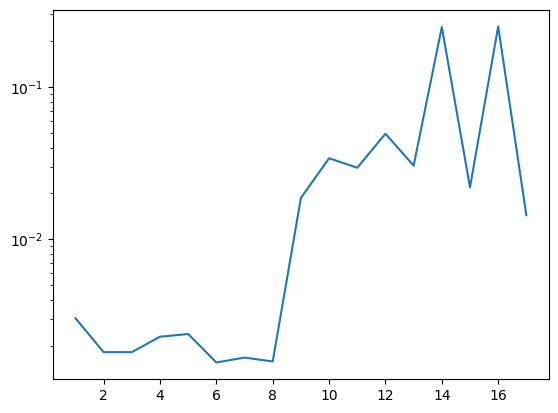

In [31]:
fig, axs = plt.subplots()
axs.plot(n_leths, med_error_rate)
axs.set_yscale("log")
